### Here we generate synthetic population of city without workplaces and schools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time as time
import random
from tqdm import tqdm
from scipy.stats import binom

In [2]:
city_name = 'spb'

In [3]:
def formAgeColumnsNames():
    list_names = []

    for gender in ['m', 'g']:
        for i in range(0, 101):
            list_names.append(gender+str(i))

    return list_names


def calcSumDwellers(df, age_names):
    sum = 0
    for name in age_names:
        sum += df[name].sum()

    return sum


def popStructure(hh_df):
    m_num = 0
    f_num = 0
    for i in range(0, 100):
        mname = 'm'+str(i)
        fname = 'g'+str(i)

        mcol = hh_df[mname].astype('float64')
        fcol = hh_df[fname].astype('float64')

        print('Males, {}:  {}'.format(mname, mcol.sum()))
        print('Females, {}:  {}'.format(fname, fcol.sum()))
        m_num = m_num + mcol.sum()
        f_num = f_num + fcol.sum()
    print("Males, total: {}".format(m_num))
    print("Females, total: {}".format(f_num))
    print("Total: {}".format(m_num+f_num))


def calcHHSize(row):
    # print(row)
    size = 0
    for gender_age in formAgeColumnsNames():
        size += int(row[gender_age])

    return size


def aggregateHouseholds(df):
    # Accumulates people by coordinates into households, leaving coords and quantities in df

    df = df[['latitude', 'longitude']+formAgeColumnsNames()]

    # for item in formAgeColumnsNames():
    #     df[item] = df[item].astype('float64')

    df = df.apply(pd.to_numeric, errors='coerce')

    df = df.groupby(['latitude', 'longitude']).agg('sum')

    hh_sizes = df.apply(calcHHSize, axis=1)
    df_add = pd.DataFrame(hh_sizes.tolist(), columns=[
                          'hh_size'], index=df.index)
    df = df.join(df_add)

    hh_size_col = df['hh_size']
    df.drop(labels=['hh_size'], axis=1, inplace=True)
    df.insert(0, 'hh_size', hh_size_col)

    print(df[:5])

    df = df.reset_index()
    return df


def findGender(str):

    if str == 'm':
        return 'M'
    else:
        return 'F'


def extractGenderAge(colname):
    return findGender(colname[:1]), int(colname[1:])


In [4]:
def generateSynthpop_v2(raw_df, output_path_people, output_path_households):
    # Optimized generation function
    sp_id_cur = 1

    hh_col_list = ['sp_id', 'stcotrbg', 'hh_size',
                   'hh_race', 'hh_income', 'latitude',	'longitude']

    hh_num = raw_df.shape[0]
    hh_ids = list(range(1, hh_num+1))
    hh_stcotrbg_list = [190000]*hh_num
    hh_race_list = [1]*hh_num
    hh_income = [0] * hh_num

    hh_add_df = pd.DataFrame(np.column_stack([hh_ids, hh_stcotrbg_list, hh_race_list, hh_income]), columns=[
                             'sp_id', 'stcotrbg', 'hh_race', 'hh_income'])

    hh_size_dic = {}

    people_gender = []
    people_age = []
    people_hh_id = []
    # print(raw_df[:5])
    # print(hh_add_df[:5])

    hh_df = hh_add_df.join(raw_df[['hh_size', 'latitude', 'longitude']])

    # print("Age group size: {}".format(calcSumDwellers(raw_df, ['m100'])))  # formAgeColumnsNames()

    # print(hh_df[:5])

    for col_name in formAgeColumnsNames():
        # print(col_name)
        gender, age = extractGenderAge(col_name)

        num_total = int(raw_df[col_name].sum())

        people_gender.extend([gender]*num_total)
        people_age.extend([age]*num_total)

        # Assigning household ids, starting from 1
        hh_id = 1
        for num_cur in raw_df[col_name]:
            if num_cur > 0:
                people_hh_id.extend([hh_id]*int(num_cur))
            hh_id += 1

    # Constructing dataframes from the acquired data

    people_num = len(people_hh_id)

    print("Total population: {}".format(people_num))
    input("Press any key to continue...")

    race_list = [1]*people_num
    relate_list = [0]*people_num
    work_id_list = school_id_list = ['X']*people_num
    sp_id_list = list(range(1, people_num+1))

    people_col_list = ['sp_id', 'sp_hh_id', 'age',
                       'sex', 'race', 'relate', 'school_id', 'work_id']

    people_df = pd.DataFrame(np.column_stack([sp_id_list, people_hh_id, people_age, people_gender,
                             race_list, relate_list, school_id_list, work_id_list]), columns=people_col_list)

    # print(people_df[:5])

    people_dtype_list = ['int64', 'int64', 'int64', 'category',
                         'int64', 'int64', 'object', 'object', 'object']

    for col, type in zip(people_col_list, people_dtype_list):
        people_df[col] = people_df[col].astype(type)

    hh_dtype_list = ['int64', 'int64', 'int64', 'int64', 'float64', 'float64']

    for col, type in zip(hh_col_list, hh_dtype_list):
        hh_df[col] = hh_df[col].astype(type)

    people_df = people_df.sort_values('sp_hh_id')

    people_df.to_csv(output_path_people, index=False, sep='\t')
    hh_df.to_csv(output_path_households, index=False, sep='\t')

In [5]:
### CHANGE FOR YOUR CITY
input_path = '../data/' + city_name + '/database_main_2023_' + city_name + '.xlsx'

output_path_people = '../data/' + city_name + '/people_' + city_name + '_2023.txt'
output_path_households = '../data/' + city_name + '/households_' + city_name + '_2023.txt'
### CHANGE FOR YOUR CITY

start_time = time.time()
print("Script started...")
# _cleant , chunksize = 1000
raw_df = pd.read_excel(input_path)
print("Data was read...")
raw_df = aggregateHouseholds(raw_df)
print("Households were aggregated...")
generateSynthpop_v2(raw_df, output_path_people, output_path_households)
print("Population generated!")
execution_time = int(time.time() - start_time)
print("Time of execution: {} min {} sec".format(
    int(execution_time/60), execution_time % 60))

Script started...
Data was read...
                     hh_size  m0  m1  m2  m3  m4  m5  m6  m7  m8  ...  g91  \
latitude  longitude                                               ...        
59.646232 30.267251        8   0   0   0   0   0   0   0   0   0  ...    0   
59.648060 30.386454        5   0   0   1   0   0   0   0   0   0  ...    0   
59.648456 30.385197        3   0   0   0   0   0   0   0   0   0  ...    0   
59.648594 30.384735        1   0   1   0   0   0   0   0   0   0  ...    0   
59.648739 30.385748        1   0   0   0   0   0   0   0   0   0  ...    0   

                     g92  g93  g94  g95  g96  g97  g98  g99  g100  
latitude  longitude                                                
59.646232 30.267251    0    0    0    0    0    0    0    0     0  
59.648060 30.386454    0    0    0    0    0    0    0    0     0  
59.648456 30.385197    0    0    0    0    0    0    0    0     0  
59.648594 30.384735    0    0    0    0    0    0    0    0     0  
59.648739 

In [6]:
people = pd.read_csv(output_path_people, sep='\t')
households = pd.read_csv(output_path_households, sep='\t')
print(people.head())
print("Total number of people in population:", len(people['sp_id'].unique()))
print(households.head())
print("Total number of households in population", len(households))

     sp_id  sp_hh_id  age sex  race  relate school_id work_id
0  1467140         1   45   M     1       0         X       X
1  1758261         1   53   M     1       0         X       X
2   925503         1   34   M     1       0         X       X
3   525005         1   20   M     1       0         X       X
4  4499052         1   60   F     1       0         X       X
Total number of people in population: 5294136
   sp_id  stcotrbg  hh_race  hh_income  hh_size   latitude  longitude
0      1    190000        1        0.0        8  59.646232  30.267251
1      2    190000        1        0.0        5  59.648060  30.386454
2      3    190000        1        0.0        3  59.648456  30.385197
3      4    190000        1        0.0        1  59.648594  30.384735
4      5    190000        1        0.0        1  59.648739  30.385748
Total number of households in population 63386


##### Now we want to split dwellings into flats

In [7]:
def generate_distribution_data(sum, num_of_samples):
    data = []
    n_i = num_of_samples
    y_i = sum
    for i in range(num_of_samples):
        x_i = binom.rvs(y_i, 1/n_i, size=1)[0]
        data.append(x_i)
        y_i = y_i - x_i
        n_i = n_i - 1
    return data


hh_id_old = people['sp_hh_id'].unique()
people_splitted = pd.DataFrame(columns=['sp_id', 'sp_hh_id', 'age',	'sex',	'race',	'relate', 'school_id', 'work_id'])
households_splitted = pd.DataFrame(columns=['sp_id', 'hh_size',	'latitude', 'longitude'])
hh_id_max = 1

people_list = []
hh_id_list = []
hh_size_list = []
hh_latitude_list = []
hh_longitude_list = []

for hh_id in tqdm(hh_id_old):
    people_in_current_dwelling = people[people['sp_hh_id'] == hh_id]
    people_list.extend(list(people_in_current_dwelling['sp_id']))
    # print(list(people_in_current_dwelling['sp_id']))
    number_of_people_in_dwelling = len(people_in_current_dwelling)
    # distribution_for_new_hh_id = np.random.poisson(2.5, number_of_people_in_dwelling)
    if (number_of_people_in_dwelling < 5):
        distribution_for_new_hh_id = [number_of_people_in_dwelling]
    else:
        distribution_for_new_hh_id = generate_distribution_data(number_of_people_in_dwelling, int(number_of_people_in_dwelling/2.5))
    
    # print(distribution_for_new_hh_id)
    # hist, bins = np.histogram(distribution_for_new_hh_id, bins=10)
    # bin_centers = (bins[1:]+bins[:-1])*0.5
    # plt.bar(bin_centers, hist)
    # if number_of_people_in_dwelling > 10:
    #     print("People in current dwelling: {}, sum of people in flats after distribution: {}  (must be equal)".format(
    #         number_of_people_in_dwelling, sum(distribution_for_new_hh_id)))
    
    if (number_of_people_in_dwelling != sum(distribution_for_new_hh_id)):
        raise RuntimeError("Mismatch")
    
    for people_in_hh_id in distribution_for_new_hh_id:
        for i in range(people_in_hh_id):
            hh_id_list.append(hh_id_max)
            hh_size_list.append(people_in_hh_id)
            hh_latitude_list.append(float(households[households['sp_id'] == hh_id].latitude))
            hh_longitude_list.append(float(households[households['sp_id'] == hh_id].longitude))
        hh_id_max+=1
        
        
# print(len(hh_id_list))   
# print(len(people_list))
people_splitted = people
people_splitted['sp_hh_id'] = hh_id_list
households_splitted['sp_id'] = hh_id_list
households_splitted['hh_size'] = hh_size_list
households_splitted['latitude'] = hh_latitude_list
households_splitted['longitude'] = hh_longitude_list

  0%|          | 0/63386 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_15932\2753418227.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hh_latitude_list.append(float(households[households['sp_id'] == hh_id].latitude))
C:\Users\user\AppData\Local\Temp\ipykernel_15932\2753418227.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hh_longitude_list.append(float(households[households['sp_id'] == hh_id].longitude))
100%|██████████| 63386/63386 [54:57<00:00, 19.22it/s]  


In [8]:
people_splitted.to_csv('../data/' + city_name + '/people_' + city_name + '_2023_splitted_dwellings.txt', sep='\t', index=0)
households_splitted.to_csv('../data/' + city_name + '/households_' + city_name + '_2023_splitted_dwellings.txt', sep='\t', index=0)

##### Done! Dwellings are splitted in population

In [9]:
hh = pd.read_csv('../data/' + city_name + '/households_' + city_name + '_2023_splitted_dwellings.txt', sep='\t')

In [10]:
people_working_age = people_splitted[people_splitted['age'] > 17]
people_working_age = people_working_age[people_splitted['age'] < 60]
print("Number of people in working age: ", len(people_working_age))

C:\Users\user\AppData\Local\Temp\ipykernel_15932\2024561746.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  people_working_age = people_working_age[people_splitted['age'] < 60]


Number of people in working age:  3186437


In [126]:
s = np.random.poisson(2.5, 33)
for index in range(len(s)):
    if s[index] == 0:
        s[index] = random.randint(2,3)

hist, bins = np.histogram(hh_id_list, bins=10)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.bar(bin_centers, hist)
s

array([1, 1, 2, 3, 5, 4, 2, 5, 1, 2, 3, 1, 2, 4, 3, 3, 3, 1, 4, 3, 3, 1,
       4, 4, 4, 4, 3, 2, 3, 5, 1, 2, 2])

<BarContainer object of 10 artists>

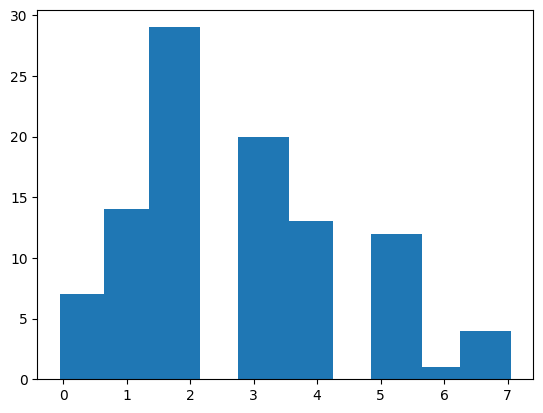

In [143]:
from scipy.stats import binom
y = 267
n = 100
n_i = n 
y_i = y


def generate_distribution_data(sum, num_of_samples):
    data = []
    n_i = num_of_samples
    y_i = sum
    for i in range(num_of_samples):
        x_i = binom.rvs(y_i, 1/n_i, size=1)[0]
        data.append(x_i)
        y_i = y_i - x_i
        n_i = n_i - 1
    return data

data = generate_distribution_data(278, 100)
hist, bins = np.histogram(data, bins=10)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.bar(bin_centers, hist)

# r = binom.rvs(n, p, size=1000)